> - 原创： lebhoryi@rt-thread.com
> - 时间： 2020/07/01
> - 内容： tensorflow2 实现线性回归:  $ y = 6*x + 10 $
> - update: convert the model from keras to tflite

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [2]:
# prepare dataset
def create(is_train):
    NUM_INPUT = 1
    true_w, true_b, NUM_SAMPLES = 6., 10, 500
    train_x = tf.random.normal(shape=(NUM_SAMPLES, NUM_INPUT),).numpy()

    train_y = true_w * train_x + true_b
    if is_train:
        noise = tf.random.normal(shape=train_y.shape, )
        train_y = train_y + noise*0.3
    return train_x, train_y

train_x, train_y = create(True)
print(train_x.shape)
print(train_y.shape)

(500, 1)
(500, 1)


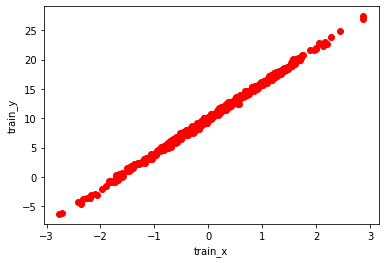

In [3]:
# plot dataset
plt.plot(train_x, train_y, 'ro', label='Original data')
plt.xlabel('train_x')
plt.ylabel('train_y')
plt.show()

## 第一种方式创建model， Sequential

In [4]:
# create model
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(5, input_shape=(1,)))
model.add(layers.Dense(1,))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


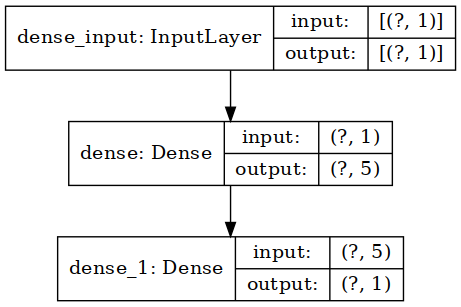

In [5]:
# save model to image
utils.plot_model(model, to_file='./image/mymodel1.png', show_shapes=True, 
        show_layer_names=True,rankdir='TB', dpi=100, expand_nested=True)

In [6]:
# save model to txt
with open('./model/model_summary.txt', 'wt') as fd:
    str_list = []
    model.summary(print_fn=lambda x:str_list.append(x))
    model_summary = '\n'.join(str_list)
    fd.write(model_summary)

## 第二种方式创建model，函数式API

```python
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(1,))
dense = layers.Dense(5)(inputs)
output = layers.Dense(1)(dense)

model = models.Model(inputs=inputs, outputs=output, name='Model')
model.summary()

```

## 第三种方式创建model，子类

```python
tf.keras.backend.clear_session()

class MyModel(models.Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)        
    
    def build(self, input_shape):
        self.dense = layers.Dense(5)
        self.dense2 = layers.Dense(input_shape[-1])
        super(MyModel, self).build(input_shape)
        
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.dense2(x)
        return x
    
model = MyModel(name='MyModel')
model.build(input_shape=(None, 1))
model.summary()

# model.variables
```

如果需要展示模型的结构，则需要重写build() 方法

In [7]:
model.compile(optimizer='sgd', loss='mean_squared_error')

model.fit(train_x, train_y, batch_size=100, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 598us/step - loss: 91.2324
Epoch 2/10
5/5 [==============================] - 0s 420us/step - loss: 14.0794
Epoch 3/10
5/5 [==============================] - 0s 651us/step - loss: 0.2768
Epoch 4/10
5/5 [==============================] - 0s 549us/step - loss: 0.0838
Epoch 5/10
5/5 [==============================] - 0s 560us/step - loss: 0.0827
Epoch 6/10
5/5 [==============================] - 0s 577us/step - loss: 0.0822
Epoch 7/10
5/5 [==============================] - 0s 627us/step - loss: 0.0833
Epoch 8/10
5/5 [==============================] - 0s 445us/step - loss: 0.0826
Epoch 9/10
5/5 [==============================] - 0s 380us/step - loss: 0.0825
Epoch 10/10
5/5 [==============================] - 0s 857us/step - loss: 0.0822


In [8]:
# predict
print(f"true_y: {10*6 + 10}")
print(f"predict: {model.predict([10,])}")

true_y: 70
predict: [[69.99734]]


In [9]:
keras_file = './model/linear.h5'
model.save(keras_file)

In [10]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [13]:
# 将 h5 model 转化为 tf lite model
tflite_model = tf.keras.models.load_model(keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
with open('./model/linear.tflite', 'wb') as f:
    f.write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmpibvcqply/assets


INFO:tensorflow:Assets written to: /tmp/tmpibvcqply/assets
